# Imports

In [37]:
import pandas as pd
import nltk
import re
import gensim
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis.gensim 

# Inspect Data for Missing or Duplicated Data

In [38]:
df = pd.read_csv("data/stocks_raw_454_posts.csv")

# check for missing values
print("missing values per column:\\n", df.isnull().sum())
# drop rows where 'Text' is empty
df = df[df["Text"].str.strip() != ""]
# check for duplicates (based on title + text)
df.drop_duplicates(subset=["Title", "Text"], inplace=True)

# save cleaned data
df.to_csv("data/stocks_cleaned.csv", index=False)
print(f"cleaned dataset saved: {len(df)} posts")

missing values per column:\n Title        0
Text         3
Upvotes      0
Comments     0
Timestamp    0
URL          0
dtype: int64
cleaned dataset saved: 341 posts


# Combine The Datasets Into a File

In [39]:
csv_files = ["data/stocks_raw_500_posts.csv", "data/stocks_raw_454_posts.csv"]
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

df.drop_duplicates(subset=["Title", "Text"], inplace=True)

df.to_csv("data/stocks_combined.csv", index=False)
print(f"combined dataset saved: {len(df)} posts")

combined dataset saved: 468 posts


# Preprocessing

In [40]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ullaangell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ullaangell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

df = pd.read_csv("data/stocks_combined.csv")

# preprocessing function
def preprocess_text(text):
    if pd.isnull(text):  # handle missing values
        return ""

    text = text.lower()
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^a-z\\s]', '', text)
    tokens = word_tokenize(text)  # tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')] 
    return " ".join(tokens)

# apply preprocessing to the "Text" column
df["Cleaned_Text"] = df["Text"].astype(str).apply(preprocess_text)

# save the cleaned dataset
df.to_csv("data/stocks_preprocessed.csv", index=False)
print(f"preprocessing complete! cleaned dataset saved: {len(df)} posts")

preprocessing complete! cleaned dataset saved: 468 posts


# Model

In [42]:
from gensim import corpora
from gensim.models import LdaModel

# tokenize the cleaned text
df["Tokenized"] = df["Cleaned_Text"].apply(lambda x: x.split())

# create a dict and corpus
dictionary = corpora.Dictionary(df["Tokenized"])
corpus = [dictionary.doc2bow(text) for text in df["Tokenized"]]

# training‼️ (adjust num_topics for different results)
num_topics = 10  # number of topics
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     alpha='auto',
                     eta='auto',
                     passes=10) # ✨the model✨

# print the topics
for idx, topic in lda_model.print_topics():
    print(f"💡 Topic {idx}: {topic}")

💡 Topic 0: 0.011*"canadaisimposingitsownpercenttariffsonbillionworthofusgoodsafteruspresidentdonaldtrumpslappedcanadawithpercenttariffsonallgoodsandpercenttariffsonoilnaturalgasandelectricityprimeministerjustintrudeausaysthetariffswilltakeeffectonbillionworthofgoodsstartingtuesdaywithafurtherbillionworthofproductsbeingtaxeddayslatertrudeauelectedtogoaheadwithretaliatorytariffseventhoughtrumpsorderincludesamechanismtoescalatetheratesifcanadaretaliatesagainsttheuscanadawillalsolookathowtolimitexportofraremineralstotheuswhicharecrucialforustechandcarcompaniesliketeslatldrtradewarisonstocksmaytakehitandbondyieldsmayspikebecauseofinflationfearssopositionyourportfoliocarefully" + 0.011*"ihaveapositioninreddititsnotanythingthatwilldestroymeifitbombsbutofcourseidontgenerallylikethrowingawaymoneyificanavoiditcurrentlythewholemarketisdownalotformostlygeopoliticalreasonsbutreddithasbeenhitespeciallyhardandsoiwantedtohearothersthoughtshereiftheythinkitisworthholdingandwaitingoutoriftheyexpectittoj

# Visualisation

In [43]:
# # visualize w/ pyLDAvis
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(vis)

In [44]:
# get the topic distribution for each document
def get_topic_distribution(lda_model, corpus):
    topic_dist = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_dist.append([prob for _, prob in topic_probs])
    
    return pd.DataFrame(topic_dist, columns=[f"Topic {i}" for i in range(lda_model.num_topics)])

# dataframe
topic_df = get_topic_distribution(lda_model, corpus)

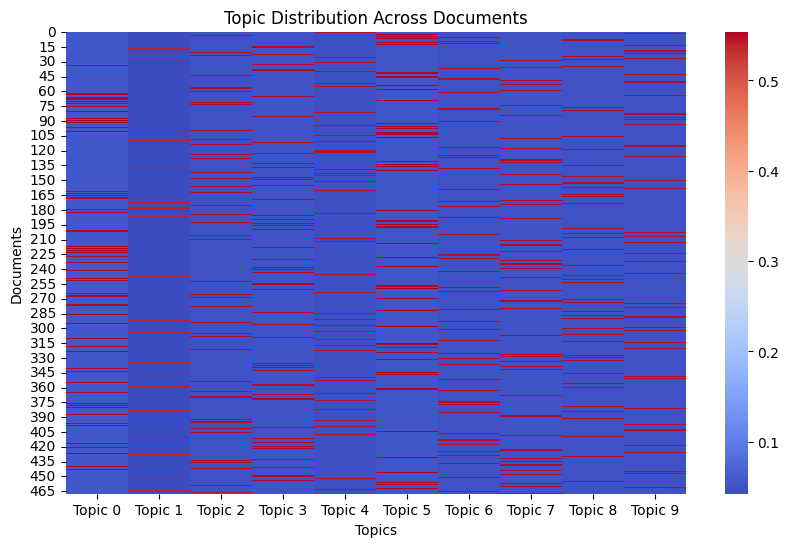

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(topic_df, cmap="coolwarm", annot=False, cbar=True)
plt.title("Topic Distribution Across Documents")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.show()